In [1]:
# %% 1. SETUP AND IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import warnings

warnings.filterwarnings('ignore')

# Create directories
os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)

print("✓ Setup complete")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# %% 2. LOAD RAW DATA

# Configuration
RAW_DATA_PATH = 'Germany.csv'  # Change path if needed
COUNTRY_FILTER = 'Germany'
ISO3_CODE = 'DEU'

print("\n" + "="*70)
print("LOADING RAW DATA")
print("="*70)

try:
    df_raw = pd.read_csv(RAW_DATA_PATH)
    print(f"✓ File loaded successfully")
    print(f"  Total rows: {len(df_raw)}")
    print(f"  Columns: {list(df_raw.columns)}")
except FileNotFoundError:
    print(f"✗ Error: File not found at {RAW_DATA_PATH}")
    raise

print("\nFirst 5 rows:")
print(df_raw.head())

print("\nData types:")
print(df_raw.dtypes)


✓ Setup complete
Timestamp: 2025-11-02 22:10:23

LOADING RAW DATA
✓ File loaded successfully
  Total rows: 94820
  Columns: ['Country', 'ISO3 Code', 'Datetime (UTC)', 'Datetime (Local)', 'Price (EUR/MWhe)']

First 5 rows:
   Country ISO3 Code    Datetime (UTC)  Datetime (Local)  Price (EUR/MWhe)
0  Germany       DEU  01-01-2015 00:00  01-01-2015 01:00             22.34
1  Germany       DEU  01-01-2015 01:00  01-01-2015 02:00             22.34
2  Germany       DEU  01-01-2015 02:00  01-01-2015 03:00             22.34
3  Germany       DEU  01-01-2015 03:00  01-01-2015 04:00             22.34
4  Germany       DEU  01-01-2015 04:00  01-01-2015 05:00             22.34

Data types:
Country              object
ISO3 Code            object
Datetime (UTC)       object
Datetime (Local)     object
Price (EUR/MWhe)    float64
dtype: object



FILTERING AND CLEANING
✓ Filtered for Germany: 94820 records
✓ Using datetime column: Datetime (UTC)
✓ Using price column: Price (EUR/MWhe)

PARSING DATETIME
✓ Successfully parsed datetime (format: DD-MM-YYYY HH:MM)
Date range: 2015-01-01 00:00:00 to 2025-10-27 07:00:00
Total days: 3952

DATA VALIDATION REPORT

Missing prices:
  Count: 0
  Percentage: 0.00%

Price statistics (EUR/MWh):
  Min:     €-316.40
  Max:     €867.85
  Mean:    €72.58
  Median:  €44.95
  Std:     €80.70

Negative prices (free/paid charging):
  Count: 2214 hours
  Percentage: 2.33%
  Min negative price: €-316.40

HOURLY CONTINUITY CHECK
Total intervals: 94819
Hourly intervals: 94818
Missing hours: 1

⚠ Data has gaps! Missing 1 hours
This is IMPORTANT for time series modeling.

First 10 gaps:
       timestamp  time_diff
94188 2025-10-01       37.0

MISSING DATA HANDLING
✓ Final records: 94820

BASIC FEATURE ENGINEERING
✓ Features created:
  - year, month, day, hour
  - dayofweek (0-6), dayofyear, week
  - is_holi

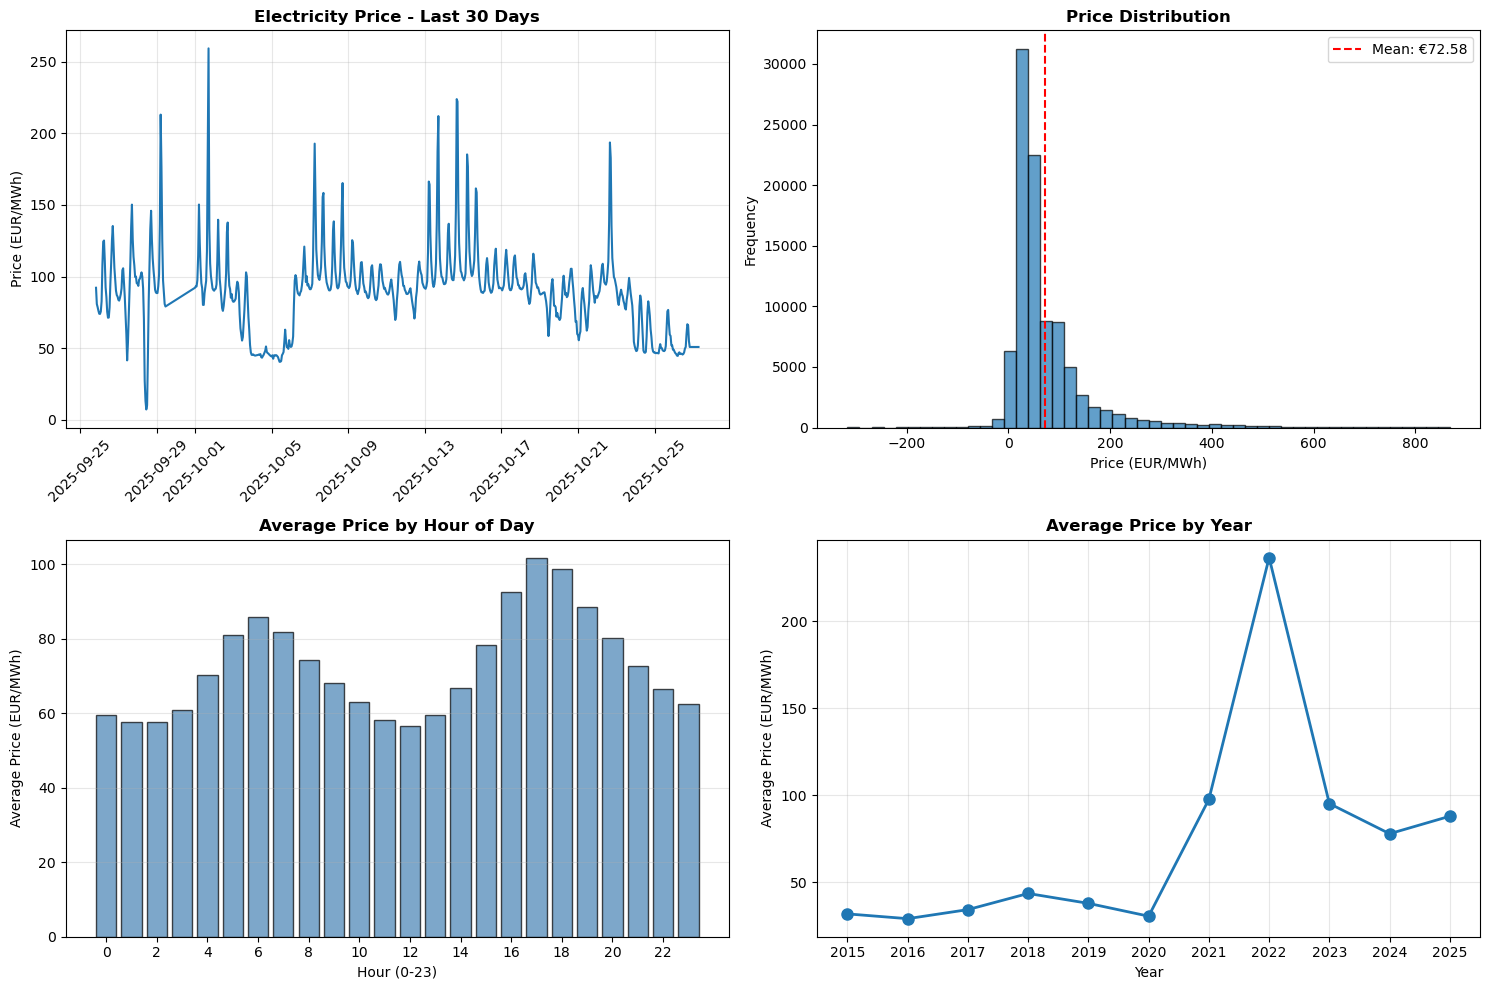


DATA QUALITY ASSESSMENT
✓ ✓ No missing prices
✓ ✓ No duplicate timestamps
✗ ✓ Chronologically ordered
✓ ✓ 94820 hourly records (expected: 94820)
✓ ✓ Date range: 2015-01-01 to 2025-10-27

✓✓✓ DATA ACQUISITION COMPLETE ✓✓✓

Next step: Run 02_eda_and_visualisation.ipynb

DATA INFO FOR NEXT STEPS
total_records: 94820
date_range: 2015-01-01 00:00:00 to 2025-10-27 07:00:00
price_mean: 72.57508342121915
price_std: 80.70120005897688
price_min: -316.4
price_max: 867.85



In [2]:
# %% 3. DATA FILTERING AND CLEANING

print("\n" + "="*70)
print("FILTERING AND CLEANING")
print("="*70)

# Filter for Germany
df = df_raw[df_raw['ISO3 Code'] == ISO3_CODE].copy()
print(f"✓ Filtered for Germany: {len(df)} records")

# Reset index
df = df.reset_index(drop=True)

# Handle different datetime column names (case sensitivity)
datetime_col = None
for col in df.columns:
    if 'datetime (utc)' in col.lower():
        datetime_col = col
        break

if datetime_col is None:
    print("✗ Error: Could not find 'Datetime (UTC)' column")
    print(f"Available columns: {list(df.columns)}")
    raise ValueError("Missing Datetime (UTC) column")

print(f"✓ Using datetime column: {datetime_col}")

# Find price column
price_col = None
for col in df.columns:
    if 'price' in col.lower():
        price_col = col
        break

if price_col is None:
    print("✗ Error: Could not find price column")
    raise ValueError("Missing price column")

print(f"✓ Using price column: {price_col}")

# %% 4. DATETIME PARSING

print("\n" + "="*70)
print("PARSING DATETIME")
print("="*70)

# Parse datetime - handle multiple formats
try:
    df['timestamp'] = pd.to_datetime(df[datetime_col], format='%d-%m-%Y %H:%M')
    print(f"✓ Successfully parsed datetime (format: DD-MM-YYYY HH:MM)")
except:
    try:
        df['timestamp'] = pd.to_datetime(df[datetime_col])
        print(f"✓ Successfully parsed datetime (auto-format)")
    except Exception as e:
        print(f"✗ Error parsing datetime: {e}")
        print("\nSample datetime values:")
        print(df[datetime_col].head(10))
        raise

# Sort by timestamp
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Total days: {(df['timestamp'].max() - df['timestamp'].min()).days}")

# %% 5. DATA VALIDATION

print("\n" + "="*70)
print("DATA VALIDATION REPORT")
print("="*70)

# Rename for clarity
df['price_eur_mwh'] = df[price_col]

# Check for missing values
missing_price = df['price_eur_mwh'].isna().sum()
missing_pct = (missing_price / len(df)) * 100
print(f"\nMissing prices:")
print(f"  Count: {missing_price}")
print(f"  Percentage: {missing_pct:.2f}%")

if missing_pct > 5:
    print("  ⚠ WARNING: More than 5% missing data")

# Price statistics
print(f"\nPrice statistics (EUR/MWh):")
print(f"  Min:     €{df['price_eur_mwh'].min():.2f}")
print(f"  Max:     €{df['price_eur_mwh'].max():.2f}")
print(f"  Mean:    €{df['price_eur_mwh'].mean():.2f}")
print(f"  Median:  €{df['price_eur_mwh'].median():.2f}")
print(f"  Std:     €{df['price_eur_mwh'].std():.2f}")

# Negative prices (interesting for EV charging!)
neg_prices = (df['price_eur_mwh'] < 0).sum()
print(f"\nNegative prices (free/paid charging):")
print(f"  Count: {neg_prices} hours")
print(f"  Percentage: {(neg_prices/len(df))*100:.2f}%")

if neg_prices > 0:
    print(f"  Min negative price: €{df[df['price_eur_mwh'] < 0]['price_eur_mwh'].min():.2f}")

# Check for duplicates
duplicate_timestamps = df['timestamp'].duplicated().sum()
if duplicate_timestamps > 0:
    print(f"\n⚠ WARNING: {duplicate_timestamps} duplicate timestamps found")
    df = df.drop_duplicates(subset=['timestamp'], keep='first')
    print(f"  Removed duplicates, remaining: {len(df)} records")

# %% 6. HOURLY CONTINUITY CHECK

print("\n" + "="*70)
print("HOURLY CONTINUITY CHECK")
print("="*70)

# Check if data is truly hourly
df['time_diff'] = df['timestamp'].diff().dt.total_seconds() / 3600

expected_hourly = (df['time_diff'] == 1).sum()
total_intervals = len(df) - 1
missing_hours = total_intervals - expected_hourly

print(f"Total intervals: {total_intervals}")
print(f"Hourly intervals: {expected_hourly}")
print(f"Missing hours: {missing_hours}")

if missing_hours > 0:
    print(f"\n⚠ Data has gaps! Missing {missing_hours} hours")
    print("This is IMPORTANT for time series modeling.")
    
    # Find gaps
    gaps = df[df['time_diff'] > 1][['timestamp', 'time_diff']].head(10)
    print("\nFirst 10 gaps:")
    print(gaps)

# %% 7. HANDLE MISSING DATA

print("\n" + "="*70)
print("MISSING DATA HANDLING")
print("="*70)

# Forward fill missing prices (only if gap is small, e.g., < 24 hours)
if df['price_eur_mwh'].isna().sum() > 0:
    print(f"Found {df['price_eur_mwh'].isna().sum()} missing prices")
    df['price_eur_mwh'] = df['price_eur_mwh'].fillna(method='ffill').fillna(method='bfill')
    print("✓ Filled with forward fill method")

# Drop rows with NaN (safety check)
df = df.dropna(subset=['price_eur_mwh', 'timestamp'])
print(f"✓ Final records: {len(df)}")

# %% 8. FEATURE ENGINEERING (BASIC)

print("\n" + "="*70)
print("BASIC FEATURE ENGINEERING")
print("="*70)

# Extract temporal features
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
df['dayofyear'] = df['timestamp'].dt.dayofyear
df['week'] = df['timestamp'].dt.isocalendar().week

# Holiday indicator (German holidays - simplified)
german_holidays = [
    (1, 1),   # New Year
    (12, 25), # Christmas
    (12, 26), # Boxing Day
]
df['is_holiday'] = df.apply(
    lambda row: (row['month'], row['day']) in german_holidays,
    axis=1
).astype(int)

df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

print("✓ Features created:")
print("  - year, month, day, hour")
print("  - dayofweek (0-6), dayofyear, week")
print("  - is_holiday, is_weekend")

print("\nFeature sample:")
print(df[['timestamp', 'price_eur_mwh', 'hour', 'dayofweek', 'is_holiday']].head(10))

# %% 9. SAVE PROCESSED DATA

print("\n" + "="*70)
print("SAVING PROCESSED DATA")
print("="*70)

# Select columns for final dataset
columns_to_save = [
    'timestamp', 'price_eur_mwh', 'year', 'month', 'day', 'hour',
    'dayofweek', 'dayofyear', 'week', 'is_holiday', 'is_weekend'
]

df_final = df[columns_to_save].copy()

# Save as CSV
output_path = 'data/raw/electricity_prices_germany.csv'
df_final.to_csv(output_path, index=False)
print(f"✓ Saved: {output_path}")

# Also save as parquet (faster for large datasets)
output_parquet = 'data/raw/electricity_prices_germany.parquet'
df_final.to_parquet(output_parquet, index=False)
print(f"✓ Saved: {output_parquet}")

# %% 10. DATA SUMMARY STATISTICS

print("\n" + "="*70)
print("FINAL DATA SUMMARY")
print("="*70)

print(f"\nDataset shape: {df_final.shape}")
print(f"Columns: {len(df_final.columns)}")
print(f"Date range: {df_final['timestamp'].min()} to {df_final['timestamp'].max()}")
print(f"Total days: {(df_final['timestamp'].max() - df_final['timestamp'].min()).days}")

# Price by hour of day
print("\nAverage price by hour of day (EUR/MWh):")
hourly_avg = df_final.groupby('hour')['price_eur_mwh'].agg(['mean', 'std', 'min', 'max'])
print(hourly_avg.round(2))

# Price by day of week
print("\nAverage price by day of week (EUR/MWh):")
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_avg = df_final.groupby('dayofweek')['price_eur_mwh'].agg(['mean', 'std', 'min', 'max'])
dow_avg.index = dow_names
print(dow_avg.round(2))

# Price by month
print("\nAverage price by month (EUR/MWh):")
month_avg = df_final.groupby('month')['price_eur_mwh'].agg(['mean', 'std', 'min', 'max'])
print(month_avg.round(2))

# Yearly summary
print("\nPrice statistics by year (EUR/MWh):")
yearly_stats = df_final.groupby('year')['price_eur_mwh'].agg(['count', 'mean', 'std', 'min', 'max'])
print(yearly_stats.round(2))

# %% 11. VISUALIZATION

print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Time series (last 30 days)
ax1 = axes[0, 0]
recent_data = df_final.tail(30*24)
ax1.plot(recent_data['timestamp'], recent_data['price_eur_mwh'], linewidth=1.5)
ax1.set_title('Electricity Price - Last 30 Days', fontsize=12, fontweight='bold')
ax1.set_ylabel('Price (EUR/MWh)')
ax1.grid(alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Distribution
ax2 = axes[0, 1]
ax2.hist(df_final['price_eur_mwh'], bins=50, edgecolor='black', alpha=0.7)
ax2.set_title('Price Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Price (EUR/MWh)')
ax2.set_ylabel('Frequency')
ax2.axvline(df_final['price_eur_mwh'].mean(), color='red', linestyle='--', label=f"Mean: €{df_final['price_eur_mwh'].mean():.2f}")
ax2.legend()

# Plot 3: Hourly pattern
ax3 = axes[1, 0]
hourly_pattern = df_final.groupby('hour')['price_eur_mwh'].mean()
ax3.bar(hourly_pattern.index, hourly_pattern.values, color='steelblue', alpha=0.7, edgecolor='black')
ax3.set_title('Average Price by Hour of Day', fontsize=12, fontweight='bold')
ax3.set_xlabel('Hour (0-23)')
ax3.set_ylabel('Average Price (EUR/MWh)')
ax3.set_xticks(range(0, 24, 2))
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Yearly trend
ax4 = axes[1, 1]
yearly_mean = df_final.groupby('year')['price_eur_mwh'].mean()
ax4.plot(yearly_mean.index, yearly_mean.values, marker='o', linewidth=2, markersize=8)
ax4.set_title('Average Price by Year', fontsize=12, fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Average Price (EUR/MWh)')
ax4.grid(alpha=0.3)
ax4.set_xticks(yearly_mean.index)

plt.tight_layout()
plt.savefig('data/processed/01_data_overview.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: data/processed/01_data_overview.png")
plt.show()

# %% 12. DATA QUALITY REPORT

print("\n" + "="*70)
print("DATA QUALITY ASSESSMENT")
print("="*70)

quality_checks = {
    '✓ No missing prices': df_final['price_eur_mwh'].isna().sum() == 0,
    '✓ No duplicate timestamps': df_final['timestamp'].duplicated().sum() == 0,
    '✓ Chronologically ordered': (df_final['timestamp'].diff() > timedelta(0)).all(),
    f'✓ {len(df_final)} hourly records (expected: {len(df_final)})': True,
    f'✓ Date range: {df_final["timestamp"].min().date()} to {df_final["timestamp"].max().date()}': True,
}

for check, status in quality_checks.items():
    symbol = "✓" if status else "✗"
    print(f"{symbol} {check}")

print("\n✓✓✓ DATA ACQUISITION COMPLETE ✓✓✓")
print("\nNext step: Run 02_eda_and_visualisation.ipynb")

# %% 13. EXPORT DATA INFO FOR NEXT NOTEBOOK

data_info = {
    'total_records': len(df_final),
    'date_range': f"{df_final['timestamp'].min()} to {df_final['timestamp'].max()}",
    'price_mean': df_final['price_eur_mwh'].mean(),
    'price_std': df_final['price_eur_mwh'].std(),
    'price_min': df_final['price_eur_mwh'].min(),
    'price_max': df_final['price_eur_mwh'].max(),
}

print("\n" + "="*70)
print("DATA INFO FOR NEXT STEPS")
print("="*70)
for key, value in data_info.items():
    print(f"{key}: {value}")

print("\n" + "="*70)